<h3> Installing java

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" 
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

<h3> Installing spark nlp and pyspark libraries

In [0]:
!pip install spark-nlp==2.6.0
!pip install pyspark==2.4.4

In [0]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
from numpy import *
import sparknlp
spark = sparknlp.start()
import os
import tweepy as tw
from array import array
import time

In [0]:
print("Spark NLP version", sparknlp.version()) 
print("Apache Spark version:", spark.version)

Spark NLP version 2.6.0
Apache Spark version: 2.4.5

<h3> Reading twitter data file

In [0]:
trainDataset = spark.read.csv('dbfs:/FileStore/tables/sample_data_200k.csv',header=True)
      
trainDataset.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+--------+
description |category|
+-------------------------------------------------------------------------------------------------------------------+--------+
spring break in plain city it s snowing |0 |
noooo it s raining today and we have to walk around arlington national cemetary |0 |
missing my italian chef |0 |
nawong how do i go about getting access to idzr org i m dying to try it out |0 |
nooooooooo this is largely private now right |0 |
talking to designers i can t squeeze any design juice from my brain for my personal website |0 |
is glad she only has to get her kids up more times before summer vacation time to get ready for work |0 |
i have a friend who is still convinced she wasn t raped by her boyfriend she said no but they were dating after all|0 |
wondering why things aren t going to plan like they should be |0 |
me neither and i m super dupe busy got vms smh i gotta go through and return calls i m tired dude |0 |
+-------------------------------------------------------------------------------------------------------------------+--------+
only showing top 10 rows

In [0]:
from pyspark.sql.functions import col
trainDataset.groupBy("category").count().orderBy(col("count").desc()).show()

+--------+-----+
category|count|
+--------+-----+
 0|95722|
 4|95572|
+--------+-----+

In [0]:
(small_subset, large_subset) = trainDataset.randomSplit([0.075, 0.3], seed = 100)

<h4> Pre-processing - creating tokenizer, normalizer and stopWordsCleaner

In [0]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")
 
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

<h3> Creating bert embeddings

In [0]:
bert_embeddings = BertEmbeddings\
 .pretrained('bert_base_cased', 'en') \
 .setInputCols(["document",'cleanTokens'])\
 .setOutputCol("bert")\
 .setCaseSensitive(False)
 
embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "bert"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")
    
embeddings_finisher = EmbeddingsFinisher() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCols(["finished_sentence_embeddings"]) \
    .setOutputAsVector(True)\
    .setCleanAnnotations(False)

bert_base_cased download started this may take some time.
Approximate size to download 389.2 MB
[ | ][OK!]

<h3> Pipelining the data

In [0]:
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
 
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")
 
 
nlp_pipeline_bert = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            bert_embeddings,
            embeddingsSentence,
            embeddings_finisher,
           label_stringIdx])

<h3> Training bert data

In [0]:
nlp_model_bert = nlp_pipeline_bert.fit(small_subset)
processed_bert = nlp_model_bert.transform(small_subset)
processed_bert.count()
#(trainingData, testData)

Out[32]: 38348

<h3> Parameter tuning

In [0]:
from pyspark.sql.functions import explode

processed_bert= processed_bert.withColumn("features", explode(processed_bert.finished_sentence_embeddings))

processed_bert.select('description','features','label').show()

+--------------------+--------------------+-----+
 description| features|label|
+--------------------+--------------------+-----+
a bbq gettin my e...|[-0.3071776628494...| 0.0|
a bit tired but w...|[0.25970175862312...| 0.0|
a bit worried sun...|[0.14532200992107...| 0.0|
a bunch of state ...|[-0.3499915003776...| 0.0|
a cant really bla...|[0.04234201088547...| 0.0|
a car full of sta...|[0.16953523457050...| 0.0|
a car killed my e...|[-0.2278826832771...| 0.0|
a certain person ...|[0.10246225446462...| 0.0|
a day n life wit ...|[-0.0039512910880...| 0.0|
a day of admin ta...|[-0.2909300923347...| 0.0|
a day of studying...|[-0.5548386573791...| 0.0|
a depressing star...|[-0.1010557115077...| 0.0|
a few good men is...|[0.05655629187822...| 0.0|
a few hours til m...|[-0.4831234216690...| 0.0|
a friend googled ...|[0.23256418108940...| 0.0|
a g e i think he ...|[-0.0842077136039...| 0.0|
a gallon gas pric...|[-0.2342527359724...| 0.0|
a guy commented h...|[-0.0754803493618...| 0.0|
a hamburger rice ...|[0.26104164123535...| 0.0|
a l hey anne i st...|[-0.2404189556837...| 0.0|
+--------------------+--------------------+-----+
only showing top 20 rows

<h3> Parameter Tuning

In [0]:
(trainingData, testData) = processed_bert.select('features','label').randomSplit([0.075, 0.925], seed = 100)processed_bert= processed_bert.withColumn("features", explode(processed_bert.finished_sentence_embeddings))
processed_bert_2 = processed_bert.select('description','features','label').where(num_nonzeros("features") == 768)
processed_bert_2.show(5)

In [0]:

@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

processed_bert= processed_bert.withColumn("features", explode(processed_bert.finished_sentence_embeddings))
processed_bert_2 = processed_bert.select('description','features','label').where(num_nonzeros("features") == 768)
processed_bert_2.show(5)

+--------------------+--------------------+-----+
 description| features|label|
+--------------------+--------------------+-----+
a bbq gettin my e...|[-0.3071776628494...| 0.0|
a bit tired but w...|[0.25970175862312...| 0.0|
a bit worried sun...|[0.14532200992107...| 0.0|
a bunch of state ...|[-0.3499915003776...| 0.0|
a cant really bla...|[0.04234201088547...| 0.0|
+--------------------+--------------------+-----+
only showing top 5 rows

<h3> Splitting data

In [0]:
(trainingData, testData) = processed_bert_2.select('features','label').randomSplit([0.75, 0.25], seed = 100)

<h3> Creating Logistic Regression model

In [0]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
 
lrModel = lr.fit(trainingData)

<h3> Finding prediction

In [0]:
predictions = lrModel.transform(testData)
 
predictions.select("features","probability","label","prediction")\
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+-----+----------+
 features| probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
[-1.2367489337921143,0.2073...|[0.9975959054003989,0.00240...| 0.0| 0.0|
[-1.2367489337921143,0.2073...|[0.9975959054003989,0.00240...| 0.0| 0.0|
[-1.2367489337921143,0.2073...|[0.9975959054003989,0.00240...| 0.0| 0.0|
[-1.2367489337921143,0.2073...|[0.9975959054003989,0.00240...| 0.0| 0.0|
[-0.26459062099456787,0.570...|[0.997233387018758,0.002766...| 0.0| 0.0|
[0.13006621599197388,0.9681...|[0.9960327401155094,0.00396...| 0.0| 0.0|
[-0.45501163601875305,0.461...|[0.9955930680456229,0.00440...| 0.0| 0.0|
[-0.6341615915298462,-0.282...|[0.9952887712124926,0.00471...| 0.0| 0.0|
[0.9451239705085754,-0.7846...|[0.993425460424147,0.006574...| 0.0| 0.0|
[-0.2637317180633545,0.6270...|[0.9925494980969558,0.00745...| 0.0| 0.0|
+------------------------------+------------------------------+-----+----------+
only showing top 10 rows

<h3> Finding accuracy of ML model

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

df = predictions.select("probability","label","prediction").toPandas()

print(classification_report(df.label, df.prediction))
print(accuracy_score(df.label, df.prediction))

<h3> Saving the ML model

In [0]:
lrModel.write().save('dbfs:/saveModel')

<h3> Streaming Twitter data

<h4> Getting developer access keys and setting connection

In [0]:
consumer_key= 'CR2mKEr2ucP5gWOSnHY4Dnc1V'
consumer_secret= '9Jz86dYrxBsSYig3XCECuD2YzptDqWmkpqNt30YacqWP7qTUQg'
access_token= '1326957645236932615-qFGyuevhlrj1DnIKP1kVs6SRGsbSyY'
access_token_secret= 'w4nlVNd1yq9rDEUSrCtGtDt3LQyz5xCzL26fWp5PT1ucI'

In [0]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

<h4> Filter tweets for covid data

In [0]:
search_words = "FDA+covid+vaccine -filter:retweets"
date_since = "2020-12-11"
date_until = "2020-12-12"

<h4> Collect tweets

In [0]:
tweets = tw.Cursor(api.search,
              q=search_words,
              tweet_mode='extended',
              geocode="42.3601,-71.0589,5mi",
              lang="en",
              since=date_since,
              until=date_until).items(5000)
tweets

Out[62]: <tweepy.cursor.ItemIterator at 0x7fb3e6984400>

In [0]:
users_locs = [[tweet.user.screen_name, tweet.user.location, tweet.full_text] for tweet in tweets]
dataset = pd.DataFrame(data=users_locs, 
                    columns=['user', "location", "description"])
dataset.head()

,user,location,description
0,ethicalpsycholo,"Boston, MA",Is Trump deliberately politicizing vaccine app...
1,BU_Law,"Boston, MA",Confused about the FDA approval process for fo...
2,ragoninstitute,"Cambridge, MA",“The process lasts in the body for about 36 ho...
3,CecilWebsterMD,Boston,Looking forward to FDA officials not being ant...
4,BenjaminConteh9,"Medford, MA","Would you buy:\n1. A product that is so good, ..."


In [0]:
len(dataset)

Out[64]: 53

<h4>Cleaning live twitter data

In [0]:
import re
corpus = []
for i in range(len(dataset)):     #  for i in range(0, 1000):
  text = dataset['description'][i]
  #text = text.lower()
  text = re.sub('(@\w+)', '', text)  # Removing @ followed by words i.e. usernames
  text = re.sub('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)   # Removing hyperlinks
  text = re.sub('\s+', ' ', text) # Removing multiple spaces with single space
  text = text.strip()
  dataset['description'][i] = text 
 # print('The current sample is: ', i)
print('COMPLETED')

<>:6: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \s
<command-825317267161373>:6: DeprecationWarning: invalid escape sequence \w
 text = re.sub('(@\w+)', '', text) # Removing @ followed by words i.e. usernames
<command-825317267161373>:7: DeprecationWarning: invalid escape sequence \w
 text = re.sub('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) # Removing hyperlinks
<command-825317267161373>:8: DeprecationWarning: invalid escape sequence \s
 text = re.sub('\s+', ' ', text) # Removing multiple spaces with single space
COMPLETED

In [0]:
spark_df = spark.createDataFrame(dataset)
spark_df.show(5)

/databricks/spark/python/pyspark/sql/session.py:577: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
 arrow_schema = pa.Schema.from_pandas(pdf, preserve_index=False)
+---------------+-------------+--------------------+
 user| location| description|
+---------------+-------------+--------------------+
ethicalpsycholo| Boston, MA|Is Trump delibera...|
 BU_Law| Boston, MA|Confused about th...|
 ragoninstitute|Cambridge, MA|“The process last...|
 CecilWebsterMD| Boston|Looking forward t...|
BenjaminConteh9| Medford, MA|Would you buy: 1....|
+---------------+-------------+--------------------+
only showing top 5 rows

<h4> Encoding bert embeddings

In [0]:
processed_bert_new_tweet = nlp_model_bert.transform(spark_df)

<h4> Parameteric Tuning Live Data

In [0]:
processed_bert_new_tweet= processed_bert_new_tweet.withColumn("features", explode(processed_bert_new_tweet.finished_sentence_embeddings))
processed_bert_new_tweet_2 = processed_bert_new_tweet.select('description','features').where(num_nonzeros("features") == 768)
processed_bert_new_tweet_2.show(5)

+--------------------+--------------------+
 description| features|
+--------------------+--------------------+
Is Trump delibera...|[0.29425099492073...|
Confused about th...|[0.30024144053459...|
“The process last...|[0.17655995488166...|
Looking forward t...|[-0.1337188482284...|
Would you buy: 1....|[0.21052804589271...|
+--------------------+--------------------+
only showing top 5 rows

<h4> Loading saved ML model for prediction

In [0]:
import sys
from pyspark.ml.classification import LogisticRegression

model_1 = lrModel.load('dbfs:/saveModel')

predictions_new_tweet = model_1.transform(processed_bert_new_tweet_2)

In [0]:
predictions_new_tweet.select("description","features","probability","prediction").show(3)

+--------------------+--------------------+--------------------+----------+
 description| features| probability|prediction|
+--------------------+--------------------+--------------------+----------+
Is Trump delibera...|[0.29425099492073...|[0.55183028491199...| 0.0|
Confused about th...|[0.30024144053459...|[0.50565839035201...| 0.0|
“The process last...|[0.17655995488166...|[0.76223871374524...| 0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 3 rows

In [0]:
pandas_df = predictions_new_tweet.select("prediction").toPandas()
pandas_df.head()

,prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


<h4> Plotting Graph

In [0]:
pandas_df['CLASS'] = pandas_df['prediction'].map({0.0: 'negative', 1.0 : 'positive'})
pie_chart = pandas_df.groupby(['CLASS']).size()

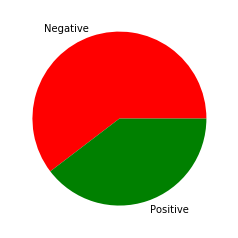

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pie(pie_chart, labels=['Negative', 'Positive'], colors=['red', 'green'])
image=plt.show()
display(image)